<a href="https://colab.research.google.com/github/BroaderOrb/BitcoinPriceModelPublic/blob/main/btc_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

# === Historical BTC prices (annual average) ===
historical_prices = [
    0.0001, 0.09, 4.25, 13.30, 754.22, 314.25, 434.33, 998.33,
    13657.20, 3843.52, 7200.17, 29374.15, 47686.81, 16625.08,
    44167.33, 94419.76
]
years = np.arange(2009, 2009 + len(historical_prices))
t_all = years - 2009

# === World GDP growth & ceiling ===
def world_gdp(t, gdp0=60e12, growth=0.03):
    return gdp0 * (1 + growth) ** t

def btc_ceiling(t, gdp_share=0.10):
    return gdp_share * world_gdp(t)

# === Model A: Power × Exponential ===
def model_power_exp(t, log_a, b, c):
    return log_a + b * np.log(t + 1e-6) + c * t

# === Model B: Power × Exp × Sigmoid (slowdown, safe) ===
def model_power_exp_sigmoid(t, log_a, b, c, d):
    sigmoid_term = np.minimum(np.exp(-d * t), 0.999999)
    return log_a + b * np.log(t + 1e-6) + c * t + np.log1p(-sigmoid_term)

# === Fit only post-2013 data ===
cut_index = np.where(years >= 2013)[0][0]
t_fit = t_all[cut_index:]
y_fit = np.log(np.array(historical_prices)[cut_index:])

# === Fit Model A ===
popt_a, _ = curve_fit(model_power_exp, t_fit, y_fit, p0=[1, 2, 0.15])
log_a_a, b_a, c_a = popt_a
a_a = np.exp(log_a_a)

# === Fit Model B ===
popt_b, _ = curve_fit(model_power_exp_sigmoid, t_fit, y_fit, p0=[1, 2, 0.15, 0.2], maxfev=10000)
log_a_b, b_b, c_b, d_b = popt_b
a_b = np.exp(log_a_b)

# === Time range for projection ===
t_proj = np.linspace(0.2, 41, 300)
years_proj = 2009 + t_proj

# === Evaluate all models ===
price_model_a = a_a * (t_proj + 1e-6)**b_a * np.exp(c_a * t_proj)
price_model_b = a_b * (t_proj + 1e-6)**b_b * np.exp(c_b * t_proj) * (1 - np.exp(-d_b * t_proj))
price_ceiling = btc_ceiling(t_proj, gdp_share=0.10)

# === Plot using log₁₀ scale ===
plt.figure(figsize=(12, 6))
plt.semilogy(years_proj, price_model_a, label="Model A: Power × Exp", linewidth=2)
plt.semilogy(years_proj, price_model_b, label="Model B: Slowed (Sigmoid)", linewidth=2)
plt.semilogy(years_proj, price_ceiling, '--', label="Ceiling: 10% of World GDP", linewidth=2)
plt.semilogy(years, historical_prices, 'o', label="Historical Data", markersize=6)

# Halving events
for year in [2012, 2016, 2020, 2024, 2028, 2032, 2036, 2040, 2044, 2048]:
    plt.axvline(x=year, color='gray', linestyle='--', alpha=0.3)

plt.xlabel("Year")
plt.ylabel("Bitcoin Price (USD, log scale)")
plt.title("Bitcoin Price Projection (Log Base 10 Scale)")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# === Export to CSV ===
df_export = pd.DataFrame({
    "Year": years_proj,
    "Price_PowerExp": price_model_a,
    "Price_SlowedSigmoid": price_model_b,
    "GDP_Ceiling_10pct": price_ceiling
})
df_export.to_csv("btc_model_projection_2050.csv", index=False)


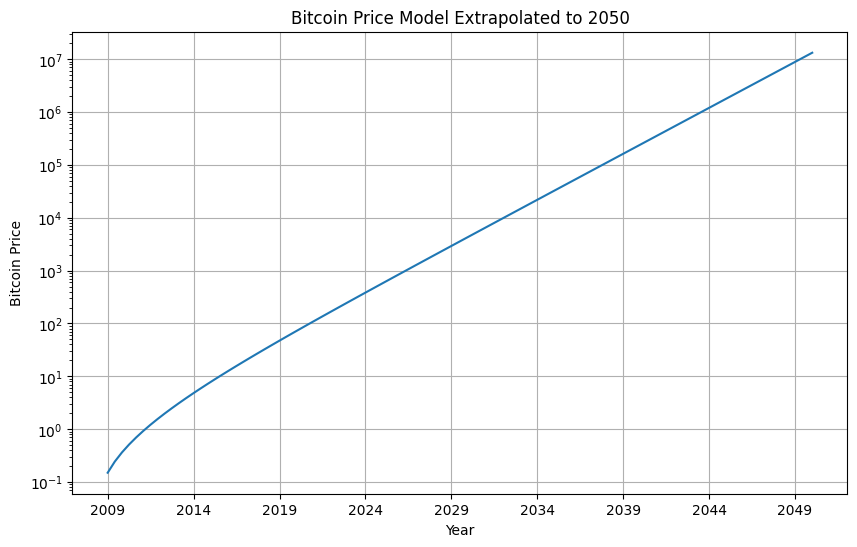

<ipython-input-7-cfac58ea2ffa>:65: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(price_model, years - 2009, historical_prices)


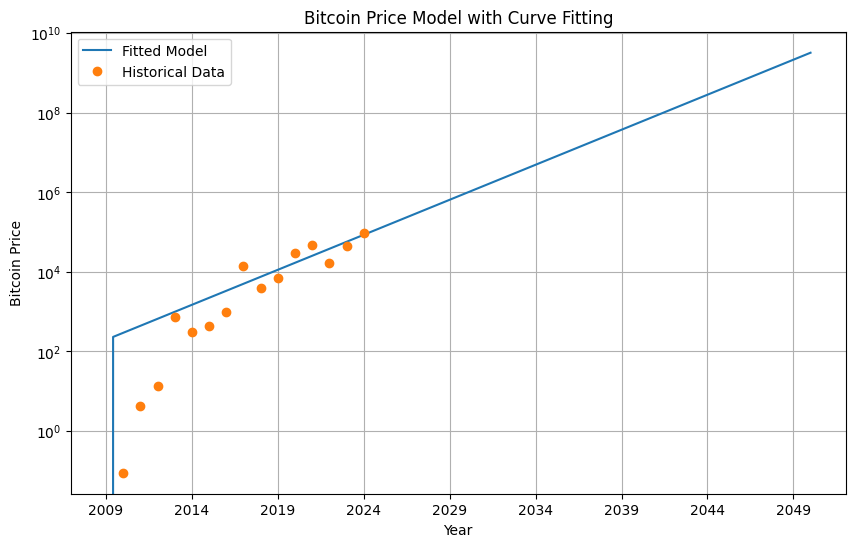